In [2]:
import pandas as pd
import numpy as np

import os
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import keras
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

from keras.preprocessing import text, sequence

from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

print(keras.__version__)

2.4.3


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Load dataset
def load_data():
    data =pd.read_csv("/content/drive/MyDrive/Covid 19 News Classification/Data/raw_data_v2.csv", engine='python')
    return data

In [7]:
tweet_df = load_data()
tweet_df.head(2)

,Unnamed: 0,Sno,Headline,Covid,Sentiment,Covid_punct,clean_covid,clean_covid_v2,clean_covid_v3,clean_covid_v4,clean_covid_v5,clean_covid_v6,covid_token,covid_token_filtered,covid_stemmed,covid_lemmatized
0,0,0,"Coronavirus cases reach 2,438 in Rajasthan; 81...",1,0,Coronavirus cases reach in Rajasthan patient...,Coronavirus cases reach in Rajasthan patient...,Coronavirus cases reach in Rajasthan patient...,Coronavirus cases reach in Rajasthan patient...,coronavirus cases reach in rajasthan patient...,coronavirus cases reach in rajasthan patient...,coronavirus cases reach in rajasthan patient...,"['coronavirus', 'cases', 'reach', 'in', 'rajas...","['coronavirus', 'cases', 'reach', 'rajasthan',...",coronaviru case reach rajasthan patient recov,coronavirus case reach rajasthan patient recover
1,1,1,"Coronavirus cases in Delhi surge to 3,439 afte...",1,0,Coronavirus cases in Delhi surge to after ne...,Coronavirus cases in Delhi surge to after ne...,Coronavirus cases in Delhi surge to after ne...,Coronavirus cases in Delhi surge to after ne...,coronavirus cases in delhi surge to after ne...,coronavirus cases in delhi surge to after ne...,coronavirus cases in delhi surge to after ne...,"['coronavirus', 'cases', 'in', 'delhi', 'surge...","['coronavirus', 'cases', 'delhi', 'surge', 'ne...",coronaviru case delhi surg new case report today,coronavirus case delhi surge new case reported...


In [8]:
tweet_df['covid_lemmatized'] = tweet_df['covid_lemmatized'].str.lower()

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
X = tweet_df['covid_lemmatized']
y = tweet_df['Covid']

In [11]:
X.shape,y.shape

((4072,), (4072,))

In [12]:
#50328 only for glove
#2000001 only for Fasttext
max_features=50328
max_len=100
sequence_input = Input(shape=(max_len, ))
embed_size=300

In [13]:
tokenizer = text.Tokenizer(num_words = max_features,lower = True
)

tokenizer.fit_on_texts(X)
X=tokenizer.texts_to_sequences(X)
X=sequence.pad_sequences(X,maxlen=max_len)

In [14]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class=1, n=3245 (50.000%)
Class=0, n=3245 (50.000%)


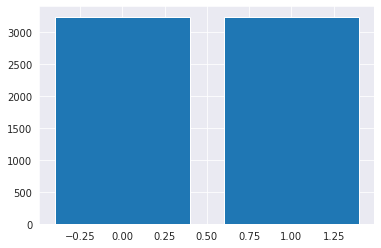

In [15]:
from matplotlib import pyplot
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [17]:
from urllib.request import urlopen
import gzip

file = gzip.open(urlopen('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz'))

In [18]:
vocab_and_vectors = {}  
for line in file:
  values = line.split()
  word = values[0].decode('utf-8')
  coefs = np.asarray(values[1:], dtype='float32')
  vocab_and_vectors[word] = coefs

In [19]:
word_index = tokenizer.word_index
len(word_index)

5443

In [20]:
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = vocab_and_vectors.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [21]:
embedding_matrix.shape

(5444, 300)

In [22]:
# Bi LSTM Implimentation
from tensorflow.keras.layers import Embedding,SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.layers.convolutional import Conv1D  
from keras.optimizers import SGD
from keras.optimizers import Adam
from tensorflow.keras import optimizers

from keras.models import Sequential
from keras.layers import Embedding,Bidirectional, Dense,Dropout
from keras.layers import Dense, Activation, Flatten
from keras import layers
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dropout

In [30]:
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional, Dense,Dropout
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dropout
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []

for train, test in kfold.split(X,y):
    ## Creating model
    model2=Sequential()
    model2.add(Embedding(5444,300,weights=[embedding_matrix],trainable=True ))
    model2.add(SpatialDropout1D(0.4))
    model2.add(Bidirectional(LSTM(128)))
    model2.add(Dropout(0.2))
    model2.add(Dense(2,activation='softmax'))
    # model2.add(Dense(1,activation='relu'))
    adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model2.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
    # Fit the model
    history = model2.fit(X[train], y[train],validation_data=(X_test, y_test),epochs=5,batch_size=128)

Epoch 1/5
41/41 [==============================] - 35s 865ms/step - loss: 0.4448 - accuracy: 0.7904 - val_loss: 0.2177 - val_accuracy: 0.9137
Epoch 2/5
41/41 [==============================] - 35s 847ms/step - loss: 0.1852 - accuracy: 0.9264 - val_loss: 0.1312 - val_accuracy: 0.9561
Epoch 3/5
41/41 [==============================] - 34s 841ms/step - loss: 0.0812 - accuracy: 0.9748 - val_loss: 0.0924 - val_accuracy: 0.9723
Epoch 4/5
41/41 [==============================] - 35s 846ms/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 0.1020 - val_accuracy: 0.9692
Epoch 5/5
41/41 [==============================] - 35s 851ms/step - loss: 0.0260 - accuracy: 0.9923 - val_loss: 0.1134 - val_accuracy: 0.9715
Epoch 1/5
41/41 [==============================] - 36s 880ms/step - loss: 0.4713 - accuracy: 0.7824 - val_loss: 0.3204 - val_accuracy: 0.8559
Epoch 2/5
41/41 [==============================] - 35s 850ms/step - loss: 0.2319 - accuracy: 0.9139 - val_loss: 0.1579 - val_accuracy: 0.9414
Epoch 

In [31]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.462772,0.762134,0.206671,0.922188
1,0.179244,0.932203,0.108982,0.966872
2,0.070976,0.976502,0.105574,0.969954
3,0.022077,0.993066,0.108430,0.966102
4,0.008606,0.998074,0.139009,0.970724


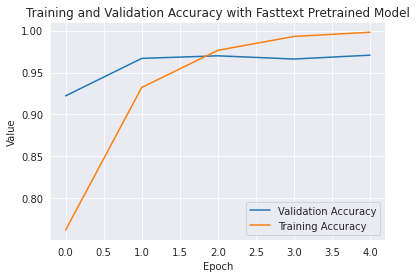

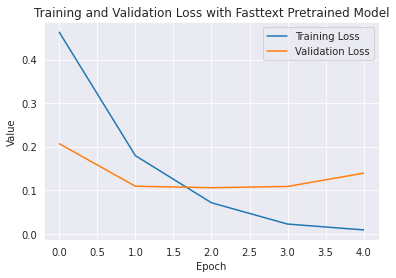

In [32]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_df['accuracy'], label='Training Accuracy')
#plt.axvline(x = 4, linewidth=1, color='r', linestyle = "--")

plt.title('Training and Validation Accuracy with Fasttext Pretrained Model')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

plt.plot(hist_df['loss'], label='Training Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
#plt.axvline(x = 4, linewidth=1, color='r', linestyle = "--")

plt.title('Training and Validation Loss with Fasttext Pretrained Model')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [33]:
y_pred=model2.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


0.9707241910631741

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       621
           1       0.98      0.96      0.97       677

    accuracy                           0.97      1298
   macro avg       0.97      0.97      0.97      1298
weighted avg       0.97      0.97      0.97      1298



In [35]:
y_score = model2.predict_proba(X_test)

Instructions for updating:
Please use `model.predict()` instead.


In [36]:
pip install scikit-plot

In [37]:
y_score

array([[9.9999857e-01, 1.3779594e-06],
       [9.9992061e-01, 7.9382633e-05],
       [4.1295698e-06, 9.9999583e-01],
       ...,
       [9.9999881e-01, 1.1918755e-06],
       [9.9999928e-01, 7.1901979e-07],
       [1.2259520e-06, 9.9999881e-01]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


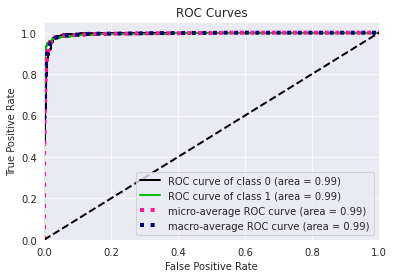

In [38]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc_curve(y_test, y_score)
plt.show()

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy:   0.971
Confusion matrix, without normalization


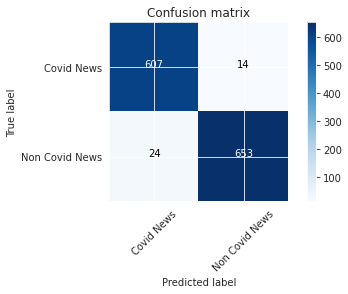

In [40]:
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import metrics
import itertools

score = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Covid News', 'Non Covid News'])